<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARIMA-14.09.2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [108]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
pd.set_option('display.max_rows', 200)

stock = "KATMR.IS"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14")

df_close = stock_data['Close']
df_log = np.log(df_close)
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

best_order = model_autoARIMA.order
print("Best ARIMA Order:", best_order)

[*********************100%%**********************]  1 of 1 completed
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10952.012, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10965.684, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10965.593, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10954.010, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10963.697, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10963.711, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10961.688, Time=2.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10967.682, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10965.695, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10965.709, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10967.591, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10963.686, Time=0.62 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 9.588 sec

In [109]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

start="2023-09-10"
end="2023-09-23"

stock_data = yf.download(stock, start=start, end=end, progress=False)
new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)

input_date_str = stock_data.index[-1].strftime("%Y-%m-%d")
input_date = datetime.strptime(input_date_str, "%Y-%m-%d")
future_date = input_date + timedelta(days=len(stock_data) - 1)

new_date_index = []
current_date = input_date

while len(new_date_index) < len(stock_data):
    if current_date.weekday() < 5:
        new_date_index.append(current_date)
    current_date += timedelta(days=1)

while len(new_date_index) > len(stock_data):
    new_date_index.pop()

model = ARIMA(np.log(stock_data["Close"]), order=best_order)
fitted = model.fit()

len(stock_data)

10

FİYAT:  2.48 TL

ÜST PROJEKSİYON:  4.05 TL
ALT PROJEKSİYON:  1.63 TL

HEDEF FİYAT:  2.57 TL



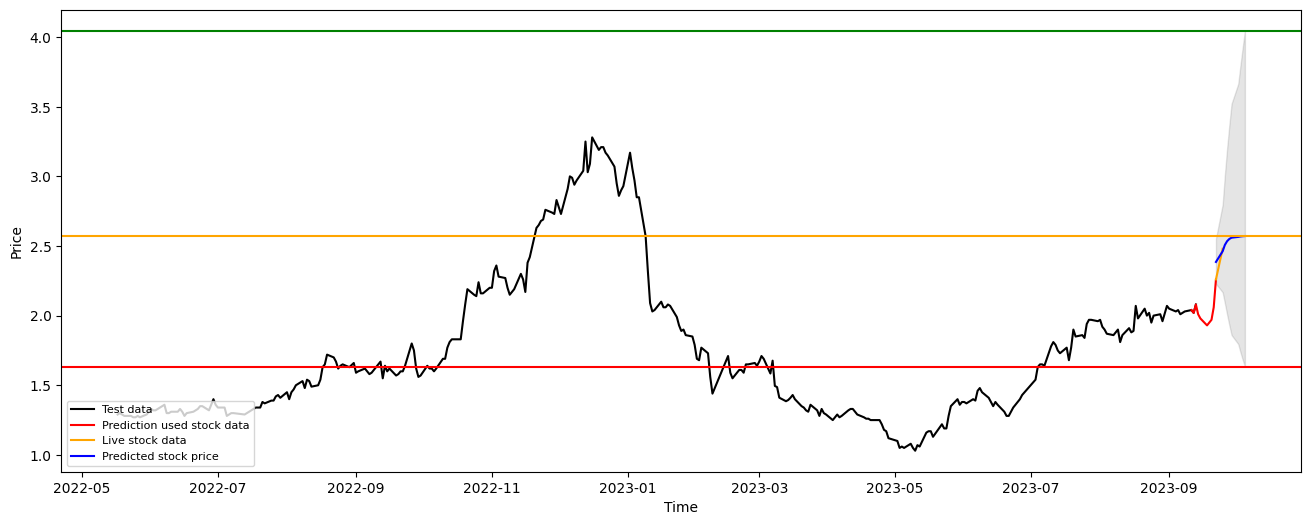

In [110]:
from datetime import datetime, timedelta

forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=stock_data.index)
lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(test_data), color='black', label='Test data')

today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow = tomorrow.strftime('%Y-%m-%d')

end = datetime.strptime(end, "%Y-%m-%d")
end = end - timedelta(days=1)
end = end.strftime("%Y-%m-%d")

# stock_data = yf.download(stock, start=end, end=tomorrow, progress=False)
plt.plot(stock_data.index, stock_data["Close"], color='red', label='Prediction used stock data')

stock_data = yf.download(stock, start=end, end=tomorrow, progress=False)
plt.plot(stock_data.index, stock_data["Close"], color='orange', label='Live stock data')

plt.plot(new_date_index, np.exp(fc), color='blue', label='Predicted stock price')  # Convert back to original scale
plt.fill_between(new_date_index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

print("FİYAT: ", round(stock_data["Close"].iloc[-1], 2), "TL\n")
print("ÜST PROJEKSİYON: ", round(np.exp(conf.iloc[:, 1].max()), 2), "TL")
print("ALT PROJEKSİYON: ", round(np.exp(conf.iloc[:, 0].min()), 2), "TL\n")

print("HEDEF FİYAT: ", round(np.exp(fc.iloc[-1]),2), "TL\n")
plt.axhline(round(np.exp(fc.iloc[-1]),2), color="orange")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [ ]:
model = ARIMA(train_data, order=best_order)
fitted = model.fit()

forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(train_data[1000:]), label='Training data', color="black")
plt.plot(np.exp(test_data), color='blue', label='Test data')

plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

In [ ]:
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

market = []

url = f"https://tr.tradingview.com/symbols/NASDAQ-NDX/components/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all(class_="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat")

  for element in elements:
    text = element.get_text()
    market.append(text)

# nasdaq100 = ['MARA', 'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN',
#              'NVDA', 'TSLA', 'META', 'AVGO', 'ASML',
#              'PEP', 'COST', 'ADBE', 'AZN', 'CSCO',
#              'NFLX', 'AMD', 'CMCSA', 'TMUS', 'TXN',
#              'QCOM', 'HON', 'INTU', 'INTC', 'SNY',
#              'VZ', 'AMGN', 'SBUX', 'ISRG', 'AMAT',
#              'BKNG', 'ADI', 'MDLZ', 'PDD', 'GILD',
#              'ADP', 'VRTX', 'ABNB', 'LRCX', 'PYPL',
#              'REGN', 'EQIX', 'MU', 'CSX', 'SNPS',
#              'CME', 'CDNS', 'KLAC', 'NTES']

# sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
# sheet_name = "Sheet_1"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# result_df = pd.read_csv(url)

bist_best_orders = pd.DataFrame()

for stock in market:
  try:
    print(stock)
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14", progress=False)

    df_close = stock_data['Close']
    df_log = np.log(df_close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

    best_order = model_autoARIMA.order
    bist_best_orders = pd.concat([bist_best_orders, pd.DataFrame([[stock, best_order]], columns=["STOCK", "BEST ORDER"])])

  except:
    pass

bist_best_orders.to_excel("NASDAQ_ORDERS.xls")

In [104]:
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
import ast
from datetime import datetime, timedelta

order_df = pd.read_excel("XUTUM_ORDERS.xls")
result_df = pd.DataFrame()

for stock in order_df["STOCK"].unique():
  best_order = order_df[order_df["STOCK"] == stock]["BEST ORDER"]
  start="2023-09-10"
  end="2023-09-23"

  stock_data = yf.download(stock, start=start, end=end, progress=False)

  model = ARIMA(np.log(stock_data["Close"]), order=ast.literal_eval(best_order.values[0]))
  fitted = model.fit()

  forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

  fc = forecast_results.predicted_mean
  conf = forecast_results.conf_int()

  fc_series = pd.Series(fc, index=stock_data.index)
  lower_series = pd.DataFrame([new_date_index, conf.iloc[:, 0]]).T

  last_predict = np.exp(fc.iloc[-1])
  first_predict = np.exp((fc.iloc[0]))

  new_end_date = pd.Timestamp(end)
  weekdays_added = 0
  while weekdays_added < 10:
      new_end_date += pd.Timedelta(days=1)
      if new_end_date.weekday() < 5:
          weekdays_added += 1

  end_date = datetime.strptime(end, "%Y-%m-%d")
  while end_date.weekday() >= 5:
      end_date -= timedelta(days=1)

  stock_data = yf.download(stock, start=end_date, end=new_end_date.strftime("%Y-%m-%d"), progress=False)
  period_change = round(((stock_data["Close"].iloc[-1] - stock_data["Close"].iloc[0]) / stock_data["Close"].iloc[0]) * 100, 2)

  if (last_predict > ((first_predict) + ((first_predict)*0.5/100))):
    result_df = pd.concat([result_df, pd.DataFrame([[stock, "UP", round(((last_predict - first_predict) / first_predict) * 100, 2), period_change]])])
  if ((last_predict + (last_predict*0.5/100)) < (first_predict)):
    result_df = pd.concat([result_df, pd.DataFrame([[stock, "DOWN", round(((last_predict - first_predict) / first_predict) * 100, 2), period_change]])])

result_df.reset_index(drop=True, inplace=True)
result_df = result_df.sort_values(by=2, ascending=False)
result_df

,0,1,2,3
22,CEMAS.IS,UP,114.64,-1.07
77,QNBFB.IS,UP,48.37,9.92
68,NIBAS.IS,UP,31.59,1.58
91,TETMT.IS,UP,24.58,-1.09
42,IHLGM.IS,UP,21.45,1.41
99,VANGD.IS,UP,17.22,-3.79
43,IHLAS.IS,UP,17.03,3.48
58,KSTUR.IS,UP,15.35,0.00
44,IHYAY.IS,UP,12.99,3.59
93,TSPOR.IS,UP,12.56,-0.90


## Deneme

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from ta import momentum, trend
import yfinance as yf

stock_symbol = 'ULKER.IS'
start_date = '2000-01-01'
end_date = '2023-12-31'

data = yf.download(stock_symbol, start=start_date, end=end_date)

# data['RSI'] = momentum.RSIIndicator(data['Close'], window=14).rsi()
# data['SMA-9'] = trend.SMAIndicator(data['Close'], window=9).sma_indicator()
# data['SMA-14'] = trend.SMAIndicator(data['Close'], window=14).sma_indicator()
# data['EMA-9'] = trend.EMAIndicator(data['Close'], window=9).ema_indicator()
# data['EMA-14'] = trend.EMAIndicator(data['Close'], window=14).ema_indicator()


data.dropna(inplace=True)

train_size = int(0.8 * len(data))
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# p_values = [0, 1, 2]
# d_values = [0, 1]
# q_values = [0, 1, 2]
# P_values = [0, 1, 2]
# D_values = [0, 1]
# Q_values = [0, 1, 2]
# s_values = [12]

best_order = (5,1,0)
best_seasonal_order = (1,1,1,12)

# for param in ParameterGrid({'p': p_values, 'd': d_values, 'q': q_values,
#                             'P': P_values, 'D': D_values, 'Q': Q_values, 's': s_values}):
#     try:
#         order = (param['p'], param['d'], param['q'])
#         seasonal_order = (param['P'], param['D'], param['Q'], param['s'])

#         model = SARIMAX(train_data['Close'], exog=train_data[['RSI', 'SMA-9', 'SMA-14', 'EMA-9', "EMA-14"]], order=order, seasonal_order=seasonal_order)
#         model_fit = model.fit(disp=0)

#         exog_test = test_data[['RSI', 'SMA-9', 'SMA-14', 'EMA-9', "EMA-14"]]
#         predictions = model_fit.forecast(steps=len(test_data), exog=exog_test)

#         mse = mean_squared_error(test_data['Close'], predictions)
#         rmse = np.sqrt(mse)

#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_order = order
#             best_seasonal_order = seasonal_order

#     except Exception as e:
#         continue

# Best SARIMA Order: (0, 0, 2)
# Best SARIMA Seasonal Order: (2, 1, 1, 12)

best_model = SARIMAX(train_data['Close'], exog=train_data[['RSI', 'SMA-9', 'SMA-14', 'EMA-9', "EMA-14"]], order=(0,0,2), seasonal_order=(2,1,1,12))
best_model_fit = best_model.fit(disp=0)
best_predictions = best_model_fit.forecast(steps=len(test_data), exog=test_data[['RSI', 'SMA-9', 'SMA-14', 'EMA-9', "EMA-14"]])

mse = mean_squared_error(test_data['Close'], best_predictions)
rmse = np.sqrt(mse)
print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")
print(f"Best Root Mean Squared Error (RMSE): {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual', color='blue')
plt.plot(test_data.index, best_predictions, label='Predicted', color='red')
plt.title(f'Stock Price Prediction for {stock_symbol} with Best SARIMA Model and Exogenous Features')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

input_date_str = test_data.index[-1] + timedelta(days=1)
input_date_str = input_date_str.strftime("%Y-%m-%d")
input_date = datetime.strptime(input_date_str, "%Y-%m-%d")
future_date = input_date + timedelta(days=13)
date_list = []
current_date = input_date
while current_date <= future_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

forecast_period = 14
exog_forecast = data[['RSI', 'SMA-9', 'SMA-14', 'EMA-9', "EMA-14"]].tail(forecast_period)
forecast = best_model_fit.forecast(steps=forecast_period, exog=exog_forecast)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index[500:], test_data['Close'][500:], label='Actual', color='blue')
plt.plot(test_data.index[500:], best_predictions[500:], label='Predicted', color='red')
plt.plot(date_list, forecast.values, label='Future Prediction', color='orange')
plt.title(f'Stock Price Prediction for {stock_symbol} with Best SARIMA Model and Exogenous Features')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
forecast_horizon = 30

last_available_date = data.index[-1]
next_dates = pd.date_range(start=last_available_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
next_features = pd.DataFrame(index=next_dates)
next_features['RSI'] = data['RSI'].tail(7).mean()
next_features['SMA-9'] = data['SMA-9'].tail(7).mean()
next_features['SMA-14'] = data['SMA-14'].tail(7).mean()
next_features['EMA-9'] = data['EMA-9'].tail(7).mean()
next_features['EMA-14'] = data['EMA-14'].tail(7).mean()

forecast = best_model_fit.forecast(steps=forecast_horizon, exog=next_features)

print("Forecasted Closing Prices for the Next 7 Days:")
print(forecast)
print(data["Close"].iloc[-1])

plt.figure(figsize=(12, 6))
plt.plot(data.index[len(data)-200:], data['Close'][len(data)-200:], label='Actual', color='blue')
plt.plot(next_dates, forecast, label='Forecasted', color='green')
plt.title(f'Stock Price Forecast for {stock_symbol} for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the stock symbol and time frame
stock_symbol = "HEKTS.IS"  # Change this to the desired stock symbol
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch stock price data from Yahoo Finance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Select only the 'Close' prices
df = data[['Close']]

# Define the number of periods ahead for prediction (1 week = 5 trading days)
forecast_periods = 31

# Perform differencing to make the time series stationary
df['Diff'] = df['Close'].diff().dropna()

# Fit SARIMAX model
order = (0, 0, 2)  # Replace with appropriate order parameters
seasonal_order = (1, 1, 1, 12)  # Replace with appropriate seasonal order parameters
exog_variables = None  # Add exogenous variables if needed

model = SARIMAX(df['Diff'], order=order, seasonal_order=seasonal_order, exog=exog_variables)
results = model.fit()

# Forecast next week's stock prices
forecast = results.forecast(steps=forecast_periods)

# Create a date range for the forecast period
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 2, closed='right')

# Invert differencing to get the actual stock price forecast
forecast_values = np.cumsum(np.concatenate(([df['Close'].iloc[-1]], forecast)))

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast_values})

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical Data', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')
plt.title(f'Stock Price Forecast for {stock_symbol}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

# Display the forecast
print(forecast_df)